In [1]:
%cd ..

/media/Windows/Users/white/Documents/UTD/Fall19/NLP.6320.501/Project/STS-Project


In [2]:
import json

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from sts_wrldom.corpusReader import read_data
from sts_wrldom.pawarModel import pawarFit_Predict, disambiguate_pipe
from sts_wrldom.utils import log_frame, accuracy, get_scores, rmse, write_results

from sts_wrldom.enrichPipe import preprocess_raw
from sts_wrldom.depTFIDFModel import depFit_Predict

In [3]:
dfs = read_data(["dev", "train"])
dev = dfs["dev"]
train = dfs["train"]
dev_train = dev.append(train)

Reading dev-set from: data/dev-set.txt
Dev DF shape: (1209, 4)
Dev Pairs Omitted: 0 = 1209 - 1209

Reading train-set from: data/train-set.txt
Train DF shape: (1484, 4)
Train Pairs Omitted: 0 = 1484 - 1484



In [4]:
%%time
dev_docs = preprocess_raw(dfs["dev"])
train_docs = preprocess_raw(dfs["train"])
dev_train_docs = dev_docs + train_docs

dev_dep_pred = depFit_Predict(dev_docs)
train_dep_pred = depFit_Predict(train_docs)
dev_train_dep_pred = depFit_Predict(dev_train_docs)

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

CPU times: user 1min 1s, sys: 1.28 s, total: 1min 2s
Wall time: 1min 2s


In [5]:
%%time
dev_disam = disambiguate_pipe(dev, "Dev")
train_disam = disambiguate_pipe(train, "Train") 

dev_pawar_pred = pawarFit_Predict(dev_disam)
train_pawar_pred = pawarFit_Predict(train_disam)
dev_train_pawar_pred = dev_pawar_pred + train_pawar_pred

Warming up PyWSD (takes ~10 secs)... took 7.2811970710754395 secs.


Disambiguating Dev...
Disambiguating Train...
CPU times: user 1min 35s, sys: 1.93 s, total: 1min 37s
Wall time: 1min 37s


In [6]:
dev_embed_pred = pd.read_csv("embeds/dev_embed_predics.csv", index_col=0)["noRound"]
train_embed_pred = pd.read_csv("embeds/train_embed_predics.csv", index_col=0)["noRound"]
dev_train_embed_pred = dev_embed_pred.append(train_embed_pred)

In [7]:
assert len(dev_dep_pred) == len(dev_pawar_pred) == len(dev_embed_pred)

In [8]:
assert len(train_dep_pred) == len(train_pawar_pred) == len(train_embed_pred)

In [9]:
assert len(dev_train_dep_pred) == len(dev_train_pawar_pred) == len(dev_train_embed_pred)

In [10]:
%%time
golds = dev["gold"]

all_acc = []
ne_acc = []
for a in np.arange(0.0, 1.1, .025):
    for b in np.arange(0.0, 1.1, .025):
        for c in np.arange(0.0, 1.1, .025):
            if (a + b + c) == 1:
                if a != 0 and b != 0 and c != 0:
                    preds = []
                    for dep, pawar, embed in zip(dev_dep_pred, dev_pawar_pred, dev_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    all_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))
                
                if a != 0 and b != 0 and c == 0:
                    preds = []
                    for dep, pawar, embed in zip(dev_dep_pred, dev_pawar_pred, dev_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    ne_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))

CPU times: user 10 s, sys: 120 ms, total: 10.1 s
Wall time: 10.1 s


In [11]:
dev_res = sorted(all_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in dev_res[:3]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.35401157981803144, params[a,b,c]:[0.4, 0.1, 0.5], rmse=1.0098767828925022, pear=(0.38559230130722294, 3.831984694201988e-44)

acc:0.35814722911497104, params[a,b,c]:[0.35000000000000003, 0.07500000000000001, 0.5750000000000001], rmse=1.0098767828925022, pear=(0.38298844028946893, 1.591283075041212e-43)

acc:0.3548387096774194, params[a,b,c]:[0.375, 0.1, 0.525], rmse=1.0127393670836666, pear=(0.3807679059426377, 5.304409892883672e-43)



In [12]:
dev_ne_res = sorted(ne_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in dev_ne_res[:3]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.3523573200992556, params[a,b,c]:[0.9750000000000001, 0.025, 0.0], rmse=1.0476646998958088, pear=(0.35881824862935624, 4.783408936030424e-38)

acc:0.3457402812241522, params[a,b,c]:[0.9500000000000001, 0.05, 0.0], rmse=1.053569300662559, pear=(0.3500985462248781, 3.493846630386299e-36)

acc:0.3465674110835401, params[a,b,c]:[0.925, 0.07500000000000001, 0.0], rmse=1.0606114315655741, pear=(0.3421785100401286, 1.5338852995682415e-34)



In [13]:
stats = pd.DataFrame(dev_res[0][4], columns=["Predic_Label"]).describe()
cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
vals = [dev_res[0][2], dev_res[0][0], dev_res[0][3][0], dev_res[0][3][1]]
extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
print(f"\nDev Gold stats: ")
print(pd.DataFrame(list(dev["gold"]), columns=["Gold_Label"]).describe().T)
print(f"\nDev Best Ensemble Model Prediction stats: ")
print(stats.append(extra).T)
print("\n------")

print(f"\nBest Dev Prediction Metrics:")
metrics = get_scores(dev_res[0][4], golds)
print(json.dumps(metrics, indent=2))


Dev Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1209.0  3.816377  1.063869  1.0  3.0  4.0  5.0  5.0

Dev Best Ensemble Model Prediction stats: 
               count      mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1209.0  4.053763  0.437771  2.0  4.0  4.0  4.0  5.0  1.009877   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label  0.354012     0.385592       3.831985e-44  

------

Best Dev Prediction Metrics:
{
  "micro": {
    "recall": 0.179,
    "precision": 0.449,
    "fscore": 0.14
  },
  "1": {
    "recall": 0.0,
    "precision": 0.0,
    "fscore": 0.0
  },
  "2": {
    "recall": 0.001,
    "precision": 1.0,
    "fscore": 0.003
  },
  "3": {
    "recall": 0.022,
    "precision": 0.195,
    "fscore": 0.039
  },
  "4": {
    "recall": 0.743,
    "precision": 0.307,
    "fscore": 0.434
  },
  "5": {
    "recall": 0.13,
    "precision": 0.745,
    "fscore": 0.221
  }
}


In [14]:
dev["prediction"] = dev_res[0][4]

In [15]:
%%time
golds = train["gold"]

t_all_acc = []
t_ne_acc = []
for a in np.arange(0.0, 1.1, .025):
    for b in np.arange(0.0, 1.1, .025):
        for c in np.arange(0.0, 1.1, .025):
            if (a + b + c) == 1:
                if a != 0 and b != 0 and c != 0:
                    preds = []
                    for dep, pawar, embed in zip(train_dep_pred, train_pawar_pred, train_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    t_all_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))
                
                if a != 0 and b != 0 and c == 0:
                    preds = []
                    for dep, pawar, embed in zip(train_dep_pred, train_pawar_pred, train_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    t_ne_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))

CPU times: user 13 s, sys: 39.8 ms, total: 13.1 s
Wall time: 13.1 s


In [16]:
train_res = sorted(t_all_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in train_res[:3]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.45754716981132076, params[a,b,c]:[0.35000000000000003, 0.025, 0.625], rmse=0.9141003855292907, pear=(0.43827612913155367, 1.0741145360804136e-70)

acc:0.45619946091644203, params[a,b,c]:[0.4, 0.025, 0.5750000000000001], rmse=0.9133629103099814, pear=(0.4371485460940911, 2.6614212267322794e-70)

acc:0.4582210242587601, params[a,b,c]:[0.325, 0.025, 0.65], rmse=0.9166768765256781, pear=(0.4343419457584354, 2.5090365690224063e-69)



In [17]:
train_ne_res = sorted(t_ne_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in train_ne_res[:3]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.42857142857142855, params[a,b,c]:[0.9750000000000001, 0.025, 0.0], rmse=0.9601212861389101, pear=(0.40063343936566626, 2.5631570881044666e-58)

acc:0.4326145552560647, params[a,b,c]:[0.9500000000000001, 0.05, 0.0], rmse=0.9601212861389101, pear=(0.3991005094631644, 7.586393565830306e-58)

acc:0.43194070080862534, params[a,b,c]:[0.925, 0.07500000000000001, 0.0], rmse=0.9646724790900519, pear=(0.3895141259203974, 5.907316805424414e-55)



In [18]:
train["prediction"] = train_res[0][4]

In [19]:
%%time
golds = dev_train["gold"]

dt_all_acc = []
dt_ne_acc = []
for a in np.arange(0.0, 1.1, .025):
    for b in np.arange(0.0, 1.1, .025):
        for c in np.arange(0.0, 1.1, .025):
            if (a + b + c) == 1:
                if a != 0 and b != 0 and c != 0:
                    preds = []
                    for dep, pawar, embed in zip(dev_train_dep_pred, dev_train_pawar_pred, dev_train_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    dt_all_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))
                
                if a != 0 and b != 0 and c == 0:
                    preds = []
                    for dep, pawar, embed in zip(dev_train_dep_pred, dev_train_pawar_pred, dev_train_embed_pred):
                        weighting = (dep * a) + (pawar * b) + (embed * c)
                        preds.append(int(np.round(weighting)))

                    acc = accuracy(preds, golds)
                    _rmse = rmse(preds, golds)
                    pear_corr = pearsonr(preds, golds)
                    dt_ne_acc.append((acc, [a, b, c], _rmse, pear_corr, preds))

CPU times: user 20.2 s, sys: 180 ms, total: 20.4 s
Wall time: 20.4 s


In [20]:
dev_train_res = sorted(dt_all_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in dev_train_res[:10]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.4103230597846268, params[a,b,c]:[0.4, 0.025, 0.5750000000000001], rmse=0.956343761558088, pear=(0.41091746819750496, 3.1536791216700846e-110)

acc:0.4103230597846268, params[a,b,c]:[0.375, 0.025, 0.6000000000000001], rmse=0.9571200147391051, pear=(0.4103025345518991, 7.151511868652823e-110)

acc:0.4095803936130709, params[a,b,c]:[0.35000000000000003, 0.025, 0.625], rmse=0.9573139796848069, pear=(0.40978689200101615, 1.4190222421519156e-109)

acc:0.41069439287040477, params[a,b,c]:[0.325, 0.025, 0.65], rmse=0.957701791724083, pear=(0.4096182584451843, 1.775000911631607e-109)

acc:0.4110657259561827, params[a,b,c]:[0.35000000000000003, 0.05, 0.6000000000000001], rmse=0.9600253740921925, pear=(0.40742731600477916, 3.214377016983729e-108)

acc:0.4095803936130709, params[a,b,c]:[0.375, 0.05, 0.5750000000000001], rmse=0.9602187521531914, pear=(0.4070072325109342, 5.587364887303476e-108)

acc:0.40883772744151503, params[a,b,c]:[0.42500000000000004, 0.025, 0.55], rmse=0.9578956388653707,

In [21]:
dev_train_ne_res = sorted(dt_ne_acc, key=lambda tup: tup[3][0], reverse=True)
for elem in dev_train_ne_res[:10]:
    print(f"acc:{elem[0]}, params[a,b,c]:{elem[1]}, rmse={elem[2]}, pear={elem[3]}\n")

acc:0.3965837356108429, params[a,b,c]:[0.9750000000000001, 0.025, 0.0], rmse=1.0038914258032772, pear=(0.37804967523357424, 3.0733488756539445e-92)

acc:0.3980690679539547, params[a,b,c]:[0.9500000000000001, 0.05, 0.0], rmse=1.0044461130686257, pear=(0.37591614525798994, 3.8526043208095424e-91)

acc:0.3976977348681768, params[a,b,c]:[0.925, 0.07500000000000001, 0.0], rmse=1.0070306138641276, pear=(0.3730369505653606, 1.1341517509755665e-89)

acc:0.39249907166728554, params[a,b,c]:[0.9, 0.1, 0.0], rmse=1.0154762327131774, pear=(0.35772641004197553, 4.15479929891508e-82)

acc:0.3965837356108429, params[a,b,c]:[0.875, 0.125, 0.0], rmse=1.0213102554807925, pear=(0.34862555955219804, 8.346617062248372e-78)

acc:0.3973264017823988, params[a,b,c]:[0.8500000000000001, 0.15000000000000002, 0.0], rmse=1.0265687007881166, pear=(0.34214251525540096, 7.960745243827402e-75)

acc:0.39955440029706646, params[a,b,c]:[0.8, 0.2, 0.0], rmse=1.0303597877630601, pear=(0.33949442795004564, 1.2522432574308954

In [22]:
dev_train["prediction"] = dev_train_res[0][4]

In [23]:
for df, name in zip([dev, train], ["dev", "train"]):
    log_frame(df, name=name, tag="ensemble_predics")
    res = df[["id", "prediction"]]
    write_results(res, name, "ensemblePredic")

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = [1, 2, 3, 4, 5]

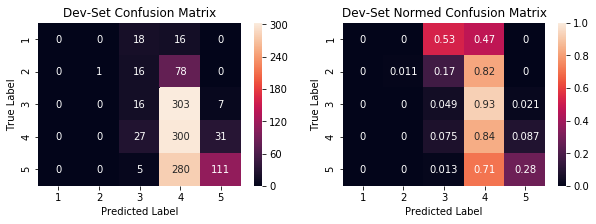

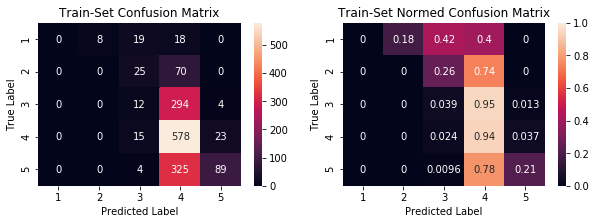

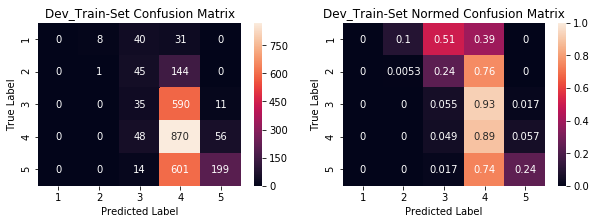

In [25]:
for df, name in zip([dev, train, dev_train], ["Dev-Set", "Train-Set", "Dev_Train-Set"]):
    cm = confusion_matrix(list(df["gold"]), list(df["prediction"]))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    f,(ax1,ax2) = plt.subplots(1,2,sharey=False, figsize=(10,3))
    g1 = sns.heatmap(df_cm,annot=True, fmt='d', ax=ax1)
    g1.set_ylabel('True Label')
    g1.set_xlabel('Predicted Label')
    g1.set_title(f'{name} Confusion Matrix')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels)
    g2 = sns.heatmap(df_cm_norm,annot=True, vmin=0, vmax=1, ax=ax2)
    g2.set_ylabel('True Label')
    g2.set_xlabel('Predicted Label')
    g2.set_title(f'{name} Normed Confusion Matrix')